In [4]:
import pandas as pd
from graph_tool.all import *
import numpy as np
import matplotlib
import csv
from datetime import datetime
import fastparquet
from tqdm import tqdm

ModuleNotFoundError: No module named 'graph_tool'

In [ ]:
from PIL import Image
import os
class PlaceCanvas:
    def __init__(self, width, height):
        self.canvas = Image.new('RGB', (width, height), color = 'white')


    def update_pixel(self, x,y,color):
        """
        Sets the specific x,y coordinate in the canvas to the given hex color.

        example:
        update_pixel(10,10,"#B4FBB8")
        """
#         h = color.lstrip('#')
#         rgb_value = tuple(int(h[i:i+2], 16) for i in (0, 2, 4))
#         self.canvas.putpixel((x,y), rgb_value)
        self.canvas.putpixel((x,y), color)

    def save_canvas(self, path = "images/"):
        if(os.path.exists(f'{path}images.png')):
            i = 0 
            while(os.path.exists(f'{path}images {i}.png')):
                i += 1
            self.canvas.save(f'{path}images {i}.png')
        else:
            self.canvas.save(f'{path}images.png')

    def get_image(self):
        return self.canvas

In [3]:
df = pd.read_parquet('2022_place_deephaven.parquet', engine='fastparquet')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [4]:
%%time
df_small = df[(df['timestamp'] > datetime.strptime('2022-04-01 12:30:00',"%Y-%m-%d %H:%M:%S")) & (df['timestamp'] < datetime.strptime('2022-04-01 23:59:00',"%Y-%m-%d %H:%M:%S"))]

CPU times: user 1.43 s, sys: 979 ms, total: 2.41 s
Wall time: 2.44 s


In [5]:
df_small.head(5)

,timestamp,user_id,rgb,x1,y1,x2,y2
0,2022-04-01 12:44:10.315,4068945,8318294,42,42,-32768,-32768
1,2022-04-01 12:44:22.671,4068946,41832,999,999,-32768,-32768
2,2022-04-01 12:44:26.626,4068947,3576042,44,42,-32768,-32768
3,2022-04-01 12:44:31.703,4068948,13948889,2,2,-32768,-32768
4,2022-04-01 12:44:44.409,4068949,3576042,23,23,-32768,-32768
...,...,...,...,...,...,...,...
42304561,2022-04-02 23:58:59.982,251570,3576042,72,915,-32768,-32768
42304562,2022-04-02 23:58:59.984,1175970,16777215,1104,941,-32768,-32768
42304563,2022-04-02 23:58:59.987,6297831,5368308,688,434,-32768,-32768
42304564,2022-04-02 23:58:59.995,1273502,0,1016,744,-32768,-32768


In [6]:
colors = ["#FFFFFF",
"#E4E4E4",
"#888888",
"#222222",
"#FFA7D1",
"#E50000",
"#E59500",
"#A06A42",
"#E5D900",
"#94E044",
"#02BE01",
"#00D3DD",
"#0083C7",
"#0000EA",
"#CF6EE4",
"#820080"]

In [8]:
dict_vertex = {}
dict_pixel = {}
dict_edges = {}


grid_size = 1000
g = Graph(directed = False)

# internal properties
v_type = g.new_vertex_property("int") # user id for last action for each pixel
v_filter = g.new_vertex_property("bool") # the color of this action
v_action_count = g.new_vertex_property("int") # action count for the user
v_id = g.new_vertex_property("string") # type of vertex
v_last_action_user = g.new_vertex_property("string") # id for vertex
v_last_vertex_date = g.new_vertex_property("string")

count = 0
# user_id = 0
canvas_2 = PlaceCanvas(1000,1000)


for row in tqdm(df_small.values):
        
  
    date = row[0]
#     try:
#         date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S")
#     except:
#         date = datetime.strptime(date, "%Y-%m-%d %H:%M:%S.%f")
    user = row[1]
    color = row[2]
    coord0 = int(row[3])
    coord1 = int(row[4])
    coords = f"{coord0}|{coord1}"
    color_str = str(color)



    if True: #date.day == 4 and date.hour < 24:
        if coord0 < grid_size and coord1 < grid_size:

#                 print(row)
            if count % 100000 == 0:
                print(date)
            canvas_2.update_pixel(coord0, coord1, color)




            if user not in dict_vertex:
                # if no user in graph add vertex to dictionary, add vertex to graph
                dict_vertex[user] = g.add_vertex() # this also adds the vertex to graph g
                v_id[dict_vertex[user]] = user # internal property of user id for graph vertices
#                 user_id += 1
                v_type[dict_vertex[user]] = 0 # internal property of vertex type
                v_action_count[dict_vertex[user]] = 1 # internal property of user's actions

            else:
                v_action_count[dict_vertex[user]] += 1 # add action count for the user
                if v_action_count[dict_vertex[user]] >2: # action count boolean property for filtering out users that did only few actions
                    v_filter[dict_vertex[user]] = True

            if f"{color}|{coords}" not in dict_vertex:
                # if no color/pixel in graph add vertex to dictionary, add vertex to graph
                dict_vertex[f"{color}|{coords}"] = g.add_vertex()  
                v_id[dict_vertex[f"{color}|{coords}"]] = f"{color}|{coords}"
                v_type[dict_vertex[f"{color}|{coords}"]] = 1
                v_filter[dict_vertex[f"{color}|{coords}"]] = True # always set to true to not filter out pixels



            if f"{user}|{color}|{coords}" not in dict_edges:
                # if a user performed exactly the same action twice we want to have it in the dictionary
                e = g.add_edge(dict_vertex[user], dict_vertex[f"{color}|{coords}"]) # add edge 
                dict_edges[f"{user}|{color}|{coords}"] = 1 # record that we added this edge already

            v_last_vertex_date[dict_vertex[user]] = date
            v_last_vertex_date[dict_vertex[f"{color}|{coords}"]] = date
            v_last_action_user[dict_vertex[f"{color}|{coords}"]] = user # overwrite the last action for a color/pixel by user id
            dict_pixel[coords] = user

            count += 1


    else: 
        break
        
        
canvas_2.save_canvas(path="")

  0%|                                                                        | 587/12258057 [00:00<1:02:37, 3262.18it/s]

2022-04-01 12:44:10.315000


  1%|▌                                                                      | 101254/12258057 [00:14<26:33, 7629.14it/s]

2022-04-01 13:21:17.579000


  2%|█▏                                                                     | 201249/12258057 [00:26<25:16, 7950.21it/s]

2022-04-01 13:31:59.251000


  2%|█▋                                                                     | 301514/12258057 [00:39<26:26, 7537.34it/s]

2022-04-01 13:41:04.762000


  3%|██▎                                                                    | 401352/12258057 [00:52<24:24, 8098.49it/s]

2022-04-01 13:49:03.401000


  4%|██▉                                                                    | 501457/12258057 [01:04<24:01, 8158.55it/s]

2022-04-01 13:56:29.777000


  5%|███▍                                                                   | 601328/12258057 [01:17<23:56, 8112.23it/s]

2022-04-01 14:03:54.199000


  6%|████                                                                   | 700982/12258057 [01:29<22:50, 8430.13it/s]

2022-04-01 14:11:22.410000


  7%|████▋                                                                  | 801264/12258057 [01:41<23:01, 8293.88it/s]

2022-04-01 14:18:40.824000


  7%|█████▏                                                                 | 901120/12258057 [01:53<22:17, 8491.36it/s]

2022-04-01 14:25:50.212000


  8%|█████▋                                                                | 1000849/12258057 [02:06<24:21, 7704.83it/s]

2022-04-01 14:32:49.360000


  9%|██████▎                                                               | 1100940/12258057 [02:18<23:14, 8002.87it/s]

2022-04-01 14:39:35.401000


 10%|██████▊                                                               | 1201145/12258057 [02:30<22:53, 8048.24it/s]

2022-04-01 14:46:11.918000


 11%|███████▍                                                              | 1300957/12258057 [02:42<21:36, 8452.47it/s]

2022-04-01 14:52:40.042000


 11%|████████                                                              | 1401215/12258057 [02:55<22:34, 8014.32it/s]

2022-04-01 14:58:57.353000


 12%|████████▌                                                             | 1501494/12258057 [03:08<23:02, 7781.61it/s]

2022-04-01 15:05:15.631000


 13%|█████████▏                                                            | 1601342/12258057 [03:21<21:59, 8074.27it/s]

2022-04-01 15:11:29.617000


 14%|█████████▋                                                            | 1700774/12258057 [03:33<23:37, 7448.88it/s]

2022-04-01 15:17:39.732000


 15%|██████████▎                                                           | 1800896/12258057 [03:46<21:25, 8133.84it/s]

2022-04-01 15:23:44.840000


 16%|██████████▊                                                           | 1900993/12258057 [03:59<22:52, 7546.02it/s]

2022-04-01 15:29:42.787000


 16%|███████████▍                                                          | 2001135/12258057 [04:20<25:52, 6606.52it/s]

2022-04-01 15:35:43.411000


 17%|████████████                                                          | 2101423/12258057 [04:33<21:56, 7717.70it/s]

2022-04-01 15:41:41.311000


 18%|████████████▌                                                         | 2201453/12258057 [04:46<21:39, 7736.97it/s]

2022-04-01 15:47:36.566000


 19%|█████████████▏                                                        | 2301233/12258057 [04:59<19:40, 8435.41it/s]

2022-04-01 15:53:25.854000


 20%|█████████████▋                                                        | 2401200/12258057 [05:11<19:38, 8364.09it/s]

2022-04-01 15:59:13.424000


 20%|██████████████▎                                                       | 2501002/12258057 [05:23<19:20, 8404.84it/s]

2022-04-01 16:05:02.091000


 21%|██████████████▊                                                       | 2601512/12258057 [05:35<19:15, 8354.12it/s]

2022-04-01 16:10:45.075000


 22%|███████████████▍                                                      | 2701261/12258057 [05:47<19:52, 8015.65it/s]

2022-04-01 16:16:24.547000


 23%|███████████████▉                                                      | 2800939/12258057 [05:59<18:24, 8565.11it/s]

2022-04-01 16:22:03.611000


 24%|████████████████▌                                                     | 2901232/12258057 [06:13<19:03, 8183.84it/s]

2022-04-01 16:27:38.853000


 24%|█████████████████▏                                                    | 3001009/12258057 [06:25<17:51, 8640.09it/s]

2022-04-01 16:33:12.478000


 25%|█████████████████▋                                                    | 3101356/12258057 [06:37<17:38, 8652.70it/s]

2022-04-01 16:38:45.363000


 26%|██████████████████▎                                                   | 3201604/12258057 [06:49<18:56, 7968.07it/s]

2022-04-01 16:44:18.442000


 27%|██████████████████▊                                                   | 3301466/12258057 [07:02<19:34, 7625.86it/s]

2022-04-01 16:49:51.242000


 28%|███████████████████▍                                                  | 3401527/12258057 [07:15<20:08, 7330.27it/s]

2022-04-01 16:55:22.756000


 29%|███████████████████▉                                                  | 3501423/12258057 [07:28<18:01, 8099.25it/s]

2022-04-01 17:00:51.183000


 29%|████████████████████▌                                                 | 3601698/12258057 [07:40<17:28, 8254.79it/s]

2022-04-01 17:06:21.618000


 30%|█████████████████████▏                                                | 3701092/12258057 [07:52<16:51, 8455.65it/s]

2022-04-01 17:11:49.749000


 31%|█████████████████████▋                                                | 3800974/12258057 [08:04<17:29, 8055.55it/s]

2022-04-01 17:17:18.211000


 32%|██████████████████████▎                                               | 3901653/12258057 [08:17<16:08, 8629.76it/s]

2022-04-01 17:22:41.043000


 33%|██████████████████████▊                                               | 4001430/12258057 [08:28<17:27, 7879.67it/s]

2022-04-01 17:27:59.573000


 33%|███████████████████████▍                                              | 4101680/12258057 [08:40<15:47, 8607.34it/s]

2022-04-01 17:33:14.149000


 34%|███████████████████████▉                                              | 4201011/12258057 [08:52<16:27, 8156.15it/s]

2022-04-01 17:38:26.372000


 35%|████████████████████████▌                                             | 4300935/12258057 [20:33<26:14, 5054.02it/s]

2022-04-01 17:43:35.343000


 36%|█████████████████████████▏                                            | 4401298/12258057 [20:48<14:14, 9190.12it/s]

2022-04-01 17:48:41.283000


 37%|█████████████████████████▎                                           | 4501989/12258057 [20:59<12:53, 10027.87it/s]

2022-04-01 17:53:47.371000


 38%|██████████████████████████▎                                           | 4601733/12258057 [21:09<12:49, 9946.46it/s]

2022-04-01 18:01:33.106000


 38%|██████████████████████████▊                                           | 4701751/12258057 [21:19<13:01, 9664.97it/s]

2022-04-01 18:07:34.549000


 39%|███████████████████████████▍                                          | 4800983/12258057 [21:30<13:26, 9251.02it/s]

2022-04-01 18:12:49.769000


 40%|███████████████████████████▉                                          | 4901567/12258057 [21:41<13:12, 9286.33it/s]

2022-04-01 18:17:56.785000


 41%|████████████████████████████▌                                         | 5001496/12258057 [21:52<13:06, 9228.58it/s]

2022-04-01 18:22:56.374000


 42%|█████████████████████████████▏                                        | 5101284/12258057 [22:03<12:57, 9204.35it/s]

2022-04-01 18:27:54.423000


 42%|█████████████████████████████▋                                        | 5201876/12258057 [22:13<12:06, 9707.54it/s]

2022-04-01 18:32:51.406000


 43%|██████████████████████████████▎                                       | 5301547/12258057 [22:24<12:42, 9128.93it/s]

2022-04-01 18:37:48.914000


 44%|██████████████████████████████▊                                       | 5401624/12258057 [22:35<12:46, 8943.82it/s]

2022-04-01 18:42:43.744000


 45%|███████████████████████████████▍                                      | 5501234/12258057 [22:47<12:27, 9043.88it/s]

2022-04-01 18:47:34.914000


 46%|███████████████████████████████▉                                      | 5601014/12258057 [22:58<13:15, 8364.34it/s]

2022-04-01 18:52:26.143000


 47%|████████████████████████████████▌                                     | 5701111/12258057 [23:10<12:07, 9018.03it/s]

2022-04-01 18:57:14.274000


 47%|█████████████████████████████████▏                                    | 5800789/12258057 [23:26<14:11, 7583.39it/s]

2022-04-01 19:02:03.531000


 48%|█████████████████████████████████▋                                    | 5900830/12258057 [23:38<12:45, 8308.05it/s]

2022-04-01 19:06:54.478000


 49%|██████████████████████████████████▎                                   | 6000597/12258057 [23:50<12:11, 8549.81it/s]

2022-04-01 19:11:45.764000


 50%|██████████████████████████████████▊                                   | 6100746/12258057 [24:04<15:48, 6492.50it/s]

2022-04-01 19:16:37.568000


 51%|███████████████████████████████████▍                                  | 6201411/12258057 [24:16<12:39, 7970.77it/s]

2022-04-01 19:21:28.126000


 51%|███████████████████████████████████▉                                  | 6300985/12258057 [24:28<11:22, 8723.67it/s]

2022-04-01 19:26:18.072000


 52%|████████████████████████████████████▌                                 | 6401248/12258057 [24:39<11:14, 8683.33it/s]

2022-04-01 19:31:03.221000


 53%|█████████████████████████████████████                                 | 6500923/12258057 [25:14<19:43, 4865.33it/s]

2022-04-01 19:35:48.002000


 54%|█████████████████████████████████████▋                                | 6601144/12258057 [25:32<15:49, 5960.14it/s]

2022-04-01 19:43:05.262000


 55%|██████████████████████████████████████▎                               | 6701313/12258057 [25:46<12:15, 7556.50it/s]

2022-04-01 19:48:41.791000


 55%|██████████████████████████████████████▊                               | 6800860/12258057 [25:59<11:58, 7595.07it/s]

2022-04-01 19:53:31.881000


 56%|███████████████████████████████████████▍                              | 6901117/12258057 [26:11<10:55, 8166.07it/s]

2022-04-01 19:58:11.753000


 57%|███████████████████████████████████████▉                              | 7001460/12258057 [26:23<10:58, 7981.08it/s]

2022-04-01 20:02:42.650000


 58%|████████████████████████████████████████▌                             | 7101091/12258057 [26:35<09:34, 8979.59it/s]

2022-04-01 20:07:09.092000


 59%|█████████████████████████████████████████                             | 7201204/12258057 [26:46<09:33, 8824.76it/s]

2022-04-01 20:11:37.543000


 60%|█████████████████████████████████████████▋                            | 7301270/12258057 [26:57<09:09, 9017.11it/s]

2022-04-01 20:16:02.649000


 60%|██████████████████████████████████████████▎                           | 7401184/12258057 [27:09<09:48, 8246.79it/s]

2022-04-01 20:20:27.090000


 61%|██████████████████████████████████████████▊                           | 7501455/12258057 [27:20<08:38, 9165.32it/s]

2022-04-01 20:24:52.352000


 62%|███████████████████████████████████████████▍                          | 7601101/12258057 [27:31<08:39, 8966.70it/s]

2022-04-01 20:29:10.579000


 63%|███████████████████████████████████████████▉                          | 7701538/12258057 [27:42<07:58, 9522.09it/s]

2022-04-01 20:33:29.058000


 64%|████████████████████████████████████████████▌                         | 7801532/12258057 [27:54<07:53, 9404.50it/s]

2022-04-01 20:37:42.492000


 64%|█████████████████████████████████████████████                         | 7901024/12258057 [28:04<07:53, 9192.30it/s]

2022-04-01 20:41:50.423000


 65%|█████████████████████████████████████████████▋                        | 8001193/12258057 [28:15<07:11, 9857.47it/s]

2022-04-01 20:46:01.945000


 66%|██████████████████████████████████████████████▎                       | 8101443/12258057 [28:26<07:04, 9788.47it/s]

2022-04-01 20:50:16.381000


 67%|██████████████████████████████████████████████▊                       | 8201512/12258057 [28:36<07:02, 9596.73it/s]

2022-04-01 20:54:27.331000


 68%|███████████████████████████████████████████████▍                      | 8301736/12258057 [28:47<07:18, 9021.77it/s]

2022-04-01 20:58:39.768000


 69%|███████████████████████████████████████████████▉                      | 8401710/12258057 [28:59<06:53, 9325.05it/s]

2022-04-01 21:02:56.658000


 69%|████████████████████████████████████████████████▌                     | 8501538/12258057 [29:10<06:46, 9245.81it/s]

2022-04-01 21:07:13.443000


 70%|█████████████████████████████████████████████████                     | 8601682/12258057 [29:21<06:22, 9554.15it/s]

2022-04-01 21:11:30.345000


 71%|█████████████████████████████████████████████████▋                    | 8701560/12258057 [29:32<06:39, 8906.32it/s]

2022-04-01 21:15:47.506000


 72%|██████████████████████████████████████████████████▎                   | 8801529/12258057 [29:44<06:45, 8515.18it/s]

2022-04-01 21:20:06.691000


 73%|██████████████████████████████████████████████████▊                   | 8901390/12258057 [29:55<06:17, 8890.42it/s]

2022-04-01 21:24:29.502000


 73%|███████████████████████████████████████████████████▍                  | 9001208/12258057 [30:06<06:09, 8805.69it/s]

2022-04-01 21:28:56.517000


 74%|███████████████████████████████████████████████████▉                  | 9101437/12258057 [30:17<06:04, 8669.25it/s]

2022-04-01 21:33:24.555000


 75%|████████████████████████████████████████████████████▌                 | 9201275/12258057 [30:31<05:35, 9118.79it/s]

2022-04-01 21:37:55.516000


 76%|█████████████████████████████████████████████████████                 | 9301403/12258057 [30:42<05:58, 8257.78it/s]

2022-04-01 21:42:27.288000


 77%|█████████████████████████████████████████████████████▋                | 9401378/12258057 [30:54<05:08, 9245.61it/s]

2022-04-01 21:47:01.637000


 78%|██████████████████████████████████████████████████████▎               | 9501572/12258057 [31:05<05:32, 8291.12it/s]

2022-04-01 21:51:40.312000


 78%|██████████████████████████████████████████████████████▊               | 9601816/12258057 [31:16<04:55, 8997.06it/s]

2022-04-01 21:56:20.203000


 79%|███████████████████████████████████████████████████████▍              | 9701274/12258057 [31:27<04:29, 9475.62it/s]

2022-04-01 22:00:43.987000


 80%|███████████████████████████████████████████████████████▉              | 9800964/12258057 [31:38<04:36, 8876.43it/s]

2022-04-01 22:05:37.154000


 81%|████████████████████████████████████████████████████████▌             | 9901807/12258057 [31:48<04:04, 9647.95it/s]

2022-04-01 22:12:32.531000


 82%|████████████████████████████████████████████████████████▎            | 10001688/12258057 [31:59<03:54, 9616.07it/s]

2022-04-01 22:17:12.222000


 82%|████████████████████████████████████████████████████████▊            | 10101590/12258057 [32:10<03:50, 9338.83it/s]

2022-04-01 22:21:35.911000


 83%|█████████████████████████████████████████████████████████▍           | 10201252/12258057 [32:20<03:35, 9530.34it/s]

2022-04-01 22:25:58.743000


 84%|█████████████████████████████████████████████████████████▉           | 10301681/12258057 [32:31<03:35, 9078.50it/s]

2022-04-01 22:30:21.737000


 85%|██████████████████████████████████████████████████████████▌          | 10401285/12258057 [32:42<03:20, 9262.16it/s]

2022-04-01 22:34:37.471000


 86%|███████████████████████████████████████████████████████████          | 10501156/12258057 [32:53<03:07, 9364.51it/s]

2022-04-01 22:38:52.208000


 86%|███████████████████████████████████████████████████████████▋         | 10601011/12258057 [33:03<02:54, 9497.87it/s]

2022-04-01 22:43:09.015000


 87%|████████████████████████████████████████████████████████████▏        | 10701388/12258057 [33:14<03:03, 8494.95it/s]

2022-04-01 22:47:21.942000


 88%|████████████████████████████████████████████████████████████▊        | 10801713/12258057 [33:25<02:27, 9848.66it/s]

2022-04-01 22:51:48.138000


 89%|█████████████████████████████████████████████████████████████▎       | 10901726/12258057 [33:35<02:17, 9867.77it/s]

2022-04-01 22:56:05.165000


 90%|█████████████████████████████████████████████████████████████       | 11001209/12258057 [33:45<02:02, 10218.31it/s]

2022-04-01 23:00:27.803000


 91%|██████████████████████████████████████████████████████████████▍      | 11101024/12258057 [33:55<01:59, 9707.44it/s]

2022-04-01 23:04:55.637000


 91%|███████████████████████████████████████████████████████████████      | 11201545/12258057 [34:06<01:48, 9748.54it/s]

2022-04-01 23:09:20.563000


 92%|███████████████████████████████████████████████████████████████▌     | 11301747/12258057 [34:16<01:39, 9604.47it/s]

2022-04-01 23:13:50.175000


 93%|████████████████████████████████████████████████████████████████▏    | 11401405/12258057 [34:26<01:31, 9377.98it/s]

2022-04-01 23:18:25.473000


 94%|████████████████████████████████████████████████████████████████▋    | 11501694/12258057 [34:37<01:19, 9540.59it/s]

2022-04-01 23:22:52.750000


 95%|█████████████████████████████████████████████████████████████████▎   | 11601042/12258057 [34:48<01:07, 9709.19it/s]

2022-04-01 23:27:20.547000


 95%|█████████████████████████████████████████████████████████████████▊   | 11701228/12258057 [35:06<00:58, 9505.60it/s]

2022-04-01 23:31:52.298000


 96%|██████████████████████████████████████████████████████████████████▍  | 11801608/12258057 [35:17<00:48, 9485.56it/s]

2022-04-01 23:36:39.480000


 97%|██████████████████████████████████████████████████████████████████▉  | 11901795/12258057 [35:27<00:36, 9672.03it/s]

2022-04-01 23:41:34.862000


 98%|███████████████████████████████████████████████████████████████████▌ | 12001351/12258057 [35:38<00:27, 9326.60it/s]

2022-04-01 23:46:16.027000


 99%|████████████████████████████████████████████████████████████████████ | 12101753/12258057 [35:49<00:17, 9163.46it/s]

2022-04-01 23:51:10.706000


100%|████████████████████████████████████████████████████████████████████▋| 12200856/12258057 [36:24<00:07, 7909.06it/s]

2022-04-01 23:56:05.546000


100%|█████████████████████████████████████████████████████████████████████| 12258057/12258057 [36:31<00:00, 5593.66it/s]


In [9]:
%%time
g.save('graph_full.gt')

CPU times: user 1.73 s, sys: 278 ms, total: 2.01 s
Wall time: 2.01 s


In [10]:
g.vp.v_type = v_type
g.vp.v_id = v_id
g.vp.v_last_action_user = v_last_action_user
g.vp.v_last_vertex_date = v_last_vertex_date

In [11]:
g

<Graph object, undirected, with 5360337 vertices and 11799409 edges, 4 internal vertex properties, at 0x7f8136597eb0>

In [12]:
old_sub = GraphView(g, v_filter)

In [13]:
sub_g = Graph(old_sub, prune=True)

In [14]:
# graph_draw(sub_g, vertex_text=sub_g.vertex_index, output="whole_graph.pdf", vertex_fill_color=sub_g.vp.v_type)

In [15]:
sub_g

<Graph object, undirected, with 4308685 vertices and 10447334 edges, 4 internal vertex properties, at 0x7f80685df640>

# Fillter out unconnected nodes

In [16]:
in_degs = sub_g.get_in_degrees(sub_g.get_vertices())
out_degs = sub_g.get_out_degrees(sub_g.get_vertices())

In [17]:
v_filter_deg = sub_g.new_vertex_property("bool")

In [18]:
for i in range(len(in_degs)):
    if (in_degs[i] != 0) or (out_degs[i] != 0):
        v_filter_deg[i] = True

In [19]:
v_con_sub_g = GraphView(sub_g, v_filter_deg)

In [20]:
v_con_sub_g

<GraphView object, undirected, with 3947994 vertices and 10447334 edges, 4 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f80685ddf60, at 0x7f80685dd510>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f80685ddf60, at 0x7f80685ddf00>, False), at 0x7f80685ddf60>

In [22]:
# graph_draw(v_con_sub_g, vertex_text=v_con_sub_g.vertex_index, output="filtered_graph.pdf", vertex_fill_color=v_con_sub_g.vp.v_type)

## Communities

In [ ]:
state = minimize_blockmodel_dl(v_con_sub_g)

In [58]:
# state.draw(output="football-sbm-fit.pdf",vertex_font_size=0.4, vertex_text=v_con_sub_g.vp.v_id)

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7c94588e50, at 0x7f7d46995330>

In [24]:
b = state.get_blocks()

In [25]:
v_con_sub_g

<GraphView object, undirected, with 39808 vertices and 80397 edges, 4 internal vertex properties, edges filtered by (<EdgePropertyMap object with value type 'bool', for Graph 0x7f1e035159c0, at 0x7f1c35d92470>, False), vertices filtered by (<VertexPropertyMap object with value type 'bool', for Graph 0x7f1e035159c0, at 0x7f1c35d93070>, False), at 0x7f1e035159c0>

In [26]:
df = pd.DataFrame(np.column_stack([list(sub_g.vp.v_id), list(b.a),list(sub_g.vp.v_type)]), columns=['id','community','type'])

In [27]:
df_last = pd.DataFrame(np.column_stack([list(sub_g.vp.v_id), list(sub_g.vp.v_last_action_user),list(sub_g.vp.v_type)]), columns=['id','last', 'type'])

In [28]:
df_last['pixel'] = df_last[df_last.type=="1"].id.str.split('|')

In [29]:
last_pixel = pd.DataFrame(np.column_stack([list(dict_pixel.keys()), list(dict_pixel.values())]), columns = ['coords','user'])

In [30]:
user_community = df[(df.community != 0) & (df.type == '0')]

In [31]:
user_community.community.value_counts()

16584    3867
18180    3586
37835    1807
39265    1601
35734    1452
16130     485
3136       26
10102       4
30369       4
Name: community, dtype: int64

In [32]:
df_vis = pd.merge(last_pixel, user_community, how = 'left', left_on='user', right_on = 'id')

In [33]:
df_vis = df_vis.dropna()[['coords','community']]

In [34]:
df_vis.to_csv('df_vis.csv')

In [34]:
df[(df.community != 0) & (df.type == '0')].community.value_counts()

16584    3867
18180    3586
37835    1807
39265    1601
35734    1452
16130     485
3136       26
10102       4
30369       4
Name: community, dtype: int64

## Community vis

In [45]:
canvas = PlaceCanvas(100,100)

In [46]:
colors = dict(zip(df_vis['community'].unique(),
                  (f'{c}' for c in matplotlib.colors.cnames.values())))

In [47]:
colors

{'#F0F8FF': '#F0F8FF',
 '#FAEBD7': '#FAEBD7',
 '#00FFFF': '#00FFFF',
 '#7FFFD4': '#7FFFD4',
 '#F0FFFF': '#F0FFFF',
 '#F5F5DC': '#F5F5DC',
 '#FFE4C4': '#FFE4C4',
 '#000000': '#000000'}

In [49]:
df_vis = df_vis.replace({"community": colors})

In [50]:
for index, row in df_vis.iterrows():
    x,y = row.coords.split("|")
    canvas.update_pixel(int(x),int(y),row.community)
    

In [51]:
canvas.save_canvas(path="")

# Full graph communities

In [64]:
g.save('graph_test.gt')

In [65]:
full_graph = load_graph('graph_test.gt')

In [5]:
full_graph = load_graph('my_graph.xml')

In [7]:
full_graph

<Graph object, directed, with 32351787 vertices and 139834505 edges, at 0x7f1e9b706ce0>

In [8]:
v1 = full_graph.vertex(8093)

In [66]:
full_graph.list_properties()

v_id                   (vertex)  (type: string)
v_last_action_user     (vertex)  (type: string)
v_type                 (vertex)  (type: int32_t)


In [67]:
full_graph.vp

{'v_type': <VertexPropertyMap object with value type 'int32_t', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b7879d0>, 'v_id': <VertexPropertyMap object with value type 'string', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b7875b0>, 'v_last_action_user': <VertexPropertyMap object with value type 'string', for Graph 0x7f1e5b9a11e0, at 0x7f1e5b786320>}

In [ ]:
in_degs = sub_g.get_in_degrees(sub_g.get_vertices())
out_degs = sub_g.get_out_degrees(sub_g.get_vertices())

In [ ]:
v_filter_deg = sub_g.new_vertex_property("bool")

# Tests

In [102]:
v_test = v_con_sub_g.vertex(4275)
v_con_sub_g.vp.v_id[v_test]

'8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='

In [104]:
for key in v_con_sub_g.vp.keys():
    print(key)

v_type
v_id


In [105]:
for edge in g.vertex(4275).all_edges():
    print(edge)

(4275, 4274)


In [115]:
v1 = old_sub.vertex(4275)

In [117]:
old_sub.vp.v_id[v1][:15]

'#00A368"1169|8"'

In [108]:
v1 = sub_g.vertex(4275)

In [118]:
sub_g.vp.v_id[v1][:15]

'8Zbajz0Scbc0fb2'

In [111]:
v1 = g.vertex(8093)

In [112]:
g.vp.v_id[v1]

'8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='

In [21]:
for edge in old_sub.vertex(4275).all_edges():
    print(edge)

In [11]:
sub_g

<Graph object, undirected, with 3994 vertices and 959 edges, 3 internal vertex properties, at 0x7f20a1c87520>

In [22]:
list(sub_g.vp.v_id)

['#D4D7D9"52|7"',
 '1',
 '#FFFFFF"24|96"',
 '#000000"15|2"',
 '#FFFFFF"64|22"',
 '#E4ABFF"0|6"',
 '#515252"54|78"',
 '#7EED56"0|0"',
 '#000000"85|29"',
 '#000000"81|94"',
 '#000000"3|0"',
 '#2450A4"68|98"',
 '11',
 '#00CC78"75|76"',
 '#FFFFFF"2|38"',
 '#000000"52|7"',
 '#FFFFFF"78|11"',
 '#DE107F"4|0"',
 '#000000"69|69"',
 '#000000"34|4"',
 '#FFFFFF"18|87"',
 '#BE0039"93|47"',
 '21',
 '#9C6926"2|65"',
 '#FFFFFF"36|99"',
 '23',
 '#000000"52|64"',
 '#000000"54|65"',
 '#FFFFFF"0|33"',
 '#51E9F4"0|4"',
 '#FFFFFF"5|57"',
 '28',
 '#000000"20|82"',
 '#000000"2|2"',
 '#FFFFFF"60|21"',
 '#E4ABFF"1|81"',
 '#FFFFFF"0|0"',
 '#515252"2|2"',
 '#000000"24|95"',
 '#000000"75|13"',
 '#FFFFFF"26|26"',
 '#000000"33|17"',
 '#FFFFFF"0|1"',
 '#000000"8|28"',
 '#FFFFFF"0|3"',
 '#000000"5|57"',
 '#000000"76|23"',
 '#7EED56"5|0"',
 '#2450A4"69|92"',
 '#000000"80|9"',
 '48',
 '#FFFFFF"21|95"',
 '50',
 '#FFFFFF"31|79"',
 '#000000"56|0"',
 '#811E9F"0|0"',
 '#FFFFFF"74|6"',
 '#FFA800"8|0"',
 '#000000"22|95"',
 '#0

In [15]:
for edge in g.vertex(200).all_edges():
    print(edge)

(200, 199)
(200, 2259)
(200, 3277)
(200, 3280)


In [16]:
for edge in sub_g.vertex(200).all_edges():
    print(edge)

(200, 199)


In [23]:
for edge in v_con_sub_g.vertex(4275).all_edges():
    print(edge)

(4275, 4276)
(4275, 5783)
(4275, 7356)
(4275, 8919)
(4275, 11625)
(4275, 13096)
(4275, 14497)
(4275, 16119)
(4275, 17713)


In [25]:
for edge in dict_vertex['8Zbajz0Scbc0fb2vYNo2BNUnW85I1/TBZPoFUTkODd4z/QRk9/AdvaDYd/F34ZTHkgtk7Nvb4a5hyMJXgfflHQ=='].all_edges():
    print(edge)

(8093, 8094)
(8093, 10976)
(8093, 14092)
(8093, 17252)
(8093, 22818)
(8093, 25944)
(8093, 28964)
(8093, 32542)
(8093, 36025)


In [256]:
dict_vertex

{'neOdfPFywDW+27oZPIQTTND8XrdpxNprL3djflcEse30DvB3cUeXmkk0433s1u6hTKS0sJlauy97nxfffnZD7A==': <Vertex object with index '0' at 0x1d59a07b0>,
 '#FFFFFF"1169|8"': <Vertex object with index '1' at 0x1d59a3370>,
 'Uj516Da76vRFlduIU/9XCjkqKkjkOadNy9l7Uou5kUQT8YLBb8+BUMHb9KhMQ07vOgMdueM4jXrAfOWspzmWFA==': <Vertex object with index '2' at 0x1d59a2340>,
 '#BE0039"9|1349"': <Vertex object with index '3' at 0x1d59a2110>,
 'lSzxKxeOO7wPnHVJZukNkE6KKpPxgfjdFYpTsgcrmsLQXj1M8VcIhxgxzNouuUU+1pgOWIZNwOI3rhZp7U3b0Q==': <Vertex object with index '4' at 0x1d59a2490>,
 '#D4D7D9"52|7"': <Vertex object with index '5' at 0x1d59a1fc0>,
 'NEPi1MYeEzOQ2ectLpueAhcHPH+2qKYLlQWgPBEGrJF1UnEZV8QVKPsZT1SviB4YfQSwUyqfgz0Lp5qnnyH4/A==': <Vertex object with index '6' at 0x1d59a2180>,
 '#FFA800"385|2"': <Vertex object with index '7' at 0x1d59a12a0>,
 '8XKUQZ6w0aHrrZM7Sevh7Fq9QFPl8wLP/XiJxvyzGVed2K9p21zNFd+XvifN6FccpGeHirL1Dsgo0hT1sJ5ZvA==': <Vertex object with index '8' at 0x1d59a1000>,
 '#000000"1|1971"': <Vertex object 

# Image segmentation

In [9]:
import matplotlib.pyplot as plt

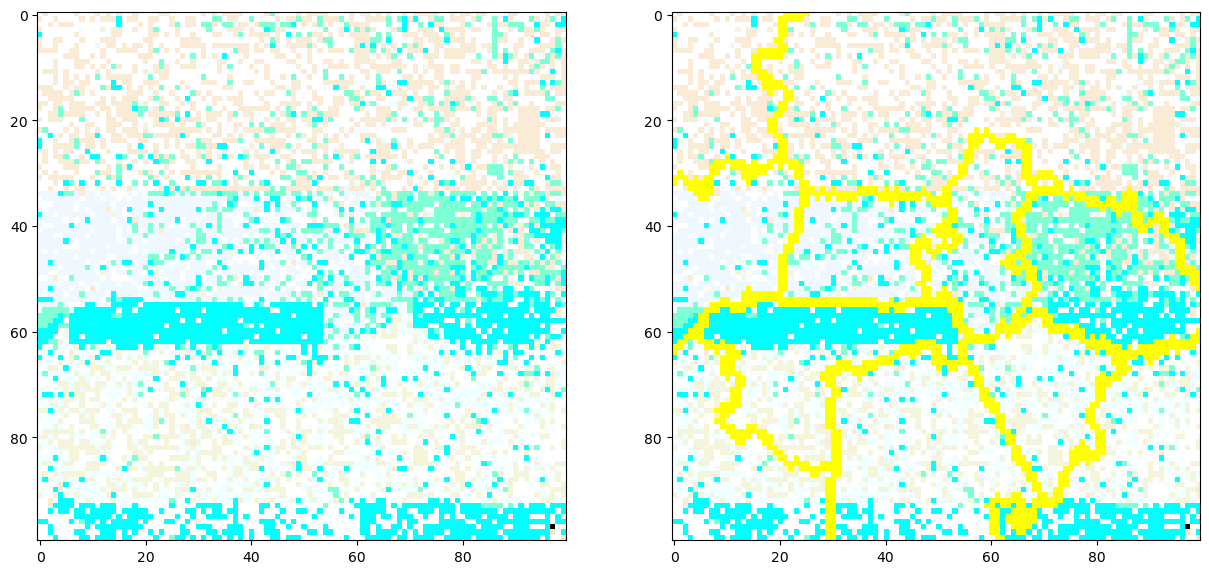

In [67]:
# Importing required boundaries
from skimage.segmentation import slic, mark_boundaries
from skimage.data import astronaut
 
# Setting the plot figure as 15, 15
plt.figure(figsize=(15, 15))
 
# Sample Image of scikit-image package
# astronaut = astronaut()
astronaut = plt.imread('images 21.png')
 
# Applying SLIC segmentation
# for the edges to be drawn over
astronaut_segments = slic(astronaut,
                          n_segments=20) #, compactness=1)
 
plt.subplot(1, 2, 1)
 
# Plotting the original image
plt.imshow(astronaut)
 
# Detecting boundaries for labels
plt.subplot(1, 2, 2)
 
# Plotting the output of marked_boundaries
# function i.e. the image with segmented boundaries
plt.imshow(mark_boundaries(astronaut, astronaut_segments))

In [62]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [65]:
astronaut_segments

array([[ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       [ 1,  1,  1, ...,  2,  2,  2],
       ...,
       [36, 36, 36, ..., 44, 44, 44],
       [36, 36, 36, ..., 44, 44, 44],
       [36, 36, 36, ..., 44, 44, 44]])

In [64]:
astronaut

array([[[1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        [1.        , 1.        , 1.        ],
        ...,
        [1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        [0.98039216, 0.92156863, 0.84313726]],

       [[0.98039216, 0.92156863, 0.84313726],
        [1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        ...,
        [0.49803922, 1.        , 0.83137256],
        [1.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ]],

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.98039216, 0.92156863, 0.84313726],
        ...,
        [1.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ],
        [0.        , 1.        , 1.        ]],

       ...,

       [[1.        , 1.        , 1.        ],
        [1.        , 1.        , 1.        ],
        [0.        , 1

In [63]:
image_show(color.label2rgb(astronaut_segments, astronaut, kind='avg'))

AttributeError: 'int' object has no attribute 'label2rgb'

In [70]:
import cv2
import numpy as np

In [95]:
# read the image
image = cv2.imread("images 21.png")

In [96]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# reshape the image to a 2D array of pixels and 3 color values (RGB)
pixel_values = image.reshape((-1, 3))
# convert to float
pixel_values = np.float32(pixel_values)

In [97]:
# define stopping criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

In [102]:
# number of clusters (K)
k = 5
_, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

In [103]:
# convert back to 8 bit values
centers = np.uint8(centers)

# flatten the labels array
labels = labels.flatten()

In [104]:
# convert all pixels to the color of the centroids
segmented_image = centers[labels.flatten()]

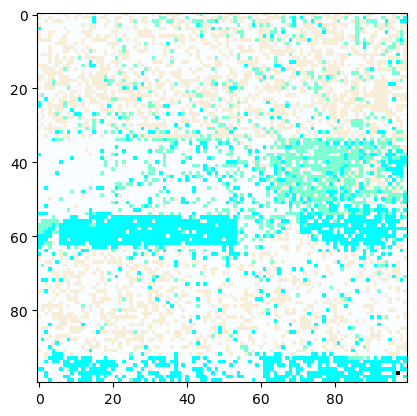

In [105]:
# reshape back to the original image dimension
segmented_image = segmented_image.reshape(image.shape)
# show the image
plt.imshow(segmented_image)
plt.show()

In [2]:
import cv2


In [ ]:
import cv2
 
# Read the original image
img = cv2.imread("images 21.png") 
# Display original image
cv2.imshow('Original', img)
# cv2.waitKey(0)
 
# Convert to graycsale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Blur the image for better edge detection
img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 
 
# Sobel Edge Detection
sobelx = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=5) # Sobel Edge Detection on the X axis
sobely = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=5) # Sobel Edge Detection on the Y axis
sobelxy = cv2.Sobel(src=img_blur, ddepth=cv2.CV_64F, dx=1, dy=1, ksize=5) # Combined X and Y Sobel Edge Detection
# Display Sobel Edge Detection Images
cv2.imshow('Sobel X', sobelx)
cv2.waitKey(0)
cv2.imshow('Sobel Y', sobely)
cv2.waitKey(0)
cv2.imshow('Sobel X Y using Sobel() function', sobelxy)
cv2.waitKey(0)
 
# Canny Edge Detection
edges = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) # Canny Edge Detection
# Display Canny Edge Detection Image
cv2.imshow('Canny Edge Detection', edges)
# cv2.waitKey(0)
 
# cv2.destroyAllWindows()

In [4]:
import numpy as np

In [13]:
img = plt.imread("images 21.png").astype(float)


In [15]:
mask = img.astype(bool)


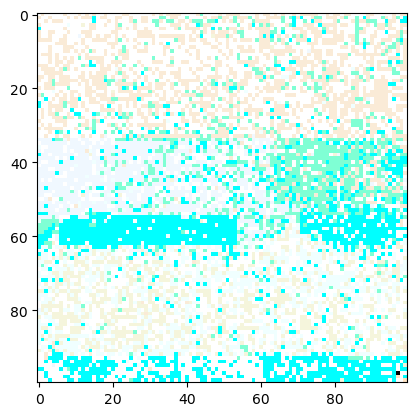

In [14]:
plt.imshow(img)

In [17]:
from sklearn.feature_extraction import image

graph = image.img_to_graph(img, mask=mask)

In [18]:
graph.data = np.exp(-graph.data / graph.data.std())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


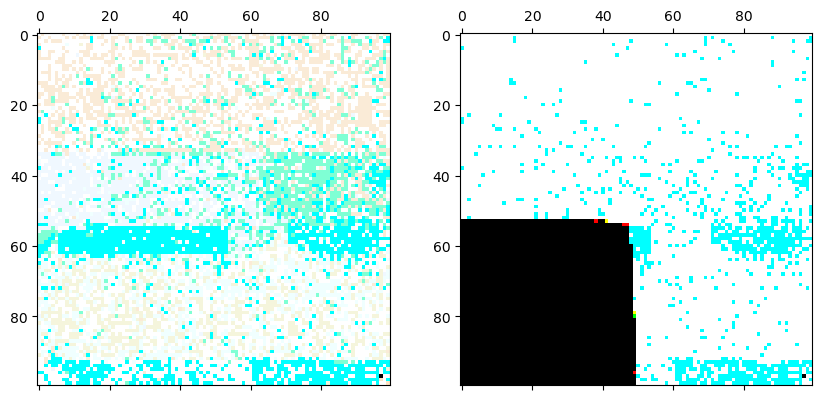

In [19]:
from sklearn.cluster import spectral_clustering
import matplotlib.pyplot as plt

labels = spectral_clustering(graph, n_clusters=4, eigen_solver="arpack")
label_im = np.full(mask.shape, -1.0)
label_im[mask] = labels

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axs[0].matshow(img)
axs[1].matshow(label_im)

plt.show()

In [3]:
astronaut

array([[[154, 147, 151],
        [109, 103, 124],
        [ 63,  58, 102],
        ...,
        [127, 120, 115],
        [120, 117, 106],
        [125, 119, 110]],

       [[177, 171, 171],
        [144, 141, 143],
        [113, 114, 124],
        ...,
        [127, 118, 112],
        [124, 115, 108],
        [121, 116, 105]],

       [[201, 194, 193],
        [182, 178, 175],
        [168, 165, 164],
        ...,
        [128, 120, 117],
        [126, 116, 112],
        [124, 114, 109]],

       ...,

       [[186, 170, 176],
        [186, 170, 177],
        [183, 168, 170],
        ...,
        [  0,   0,   0],
        [  0,   0,   1],
        [  0,   0,   0]],

       [[183, 169, 170],
        [182, 167, 171],
        [185, 164, 176],
        ...,
        [  0,   0,   1],
        [  1,   1,   1],
        [  0,   0,   0]],

       [[184, 167, 172],
        [183, 165, 169],
        [180, 162, 171],
        ...,
        [  0,   0,   0],
        [  1,   1,   1],
        [  0,   0,   0]]

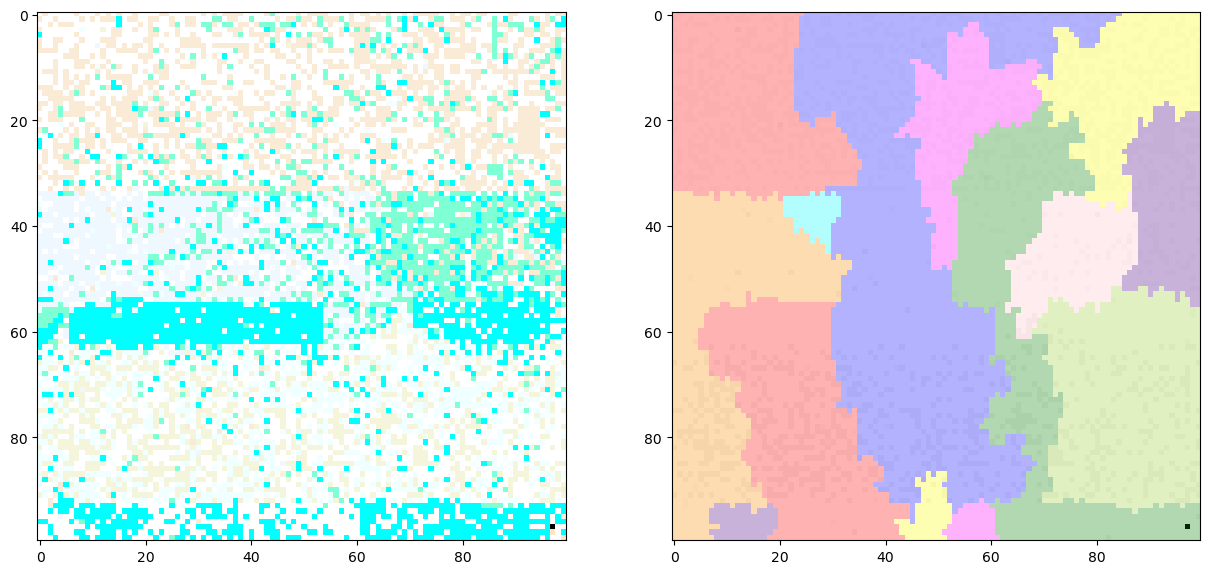

In [15]:
# Importing required libraries
from skimage.segmentation import slic
from skimage.data import astronaut
from skimage.color import label2rgb
import matplotlib.pyplot as plt 
# Setting the plot size as 15, 15
plt.figure(figsize=(15,15))
 
# Sample Image of scikit-image package
# astronaut = astronaut()
astronaut = plt.imread('images 21.png')
# Applying Simple Linear Iterative
# Clustering on the image
# - 50 segments & compactness = 10
astronaut_segments = slic(astronaut,
                          n_segments=100,
                          compactness=1)
plt.subplot(1,2,1)
 
# Plotting the original image
plt.imshow(astronaut)
plt.subplot(1,2,2)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
plt.imshow(label2rgb(astronaut_segments,
                     astronaut,
                     kind = 'overlay'))

In [16]:
colors

UsageError: %colors: you must specify a color scheme. See '%colors?'


In [24]:
import cv2
from PIL import ImageColor
import numpy as np

In [58]:
im = cv2.imread('images 21.png') # read input image

def getClosestColor(pixel,color_set_rgb): # Get the closest color for the pixel
    closest_color = None
    cost_init = 10000
    pixel = np.array(pixel)
    for color in color_set_rgb:
        color = np.array(color)
        cost = np.sum((color - pixel)**2)
        if cost < cost_init:
            cost_init = cost
            closest_color = color
    return closest_color

def getClosestImage(im): # Get the closest image
    color_set = [
 '#faebd7',
 '#f5f5dc',
 '#f0ffff',
 '#7fffd4',
 '#00ffff',
 '#ffe4c4',
 '#f0f8ff'] # Given Colorset
    color_set_rgb= [ImageColor.getrgb(color) for color in color_set] # RGB Colorset

    height, width, channels = im.shape
    im_out = np.zeros((height,width,channels))

    for y in range(0, height):
        for x in range(0, width):
            closest_color = getClosestColor(im[y, x],color_set_rgb)
            im_out[y,x,:] = closest_color
    return im_out

In [59]:
from PIL import Image
img = Image.open('images 21.png')
colr = img.getcolors()


In [60]:
colr

[(3468, (255, 255, 255)),
 (1485, (250, 235, 215)),
 (833, (245, 245, 220)),
 (997, (240, 255, 255)),
 (933, (127, 255, 212)),
 (1442, (0, 255, 255)),
 (2, (255, 228, 196)),
 (839, (240, 248, 255)),
 (1, (0, 0, 0))]

In [61]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb
rgb_to_hex((255, 255, 195))

'ffffc3'

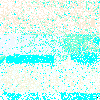

In [62]:
img

In [63]:
[f'#{rgb_to_hex(color[1])}' for color in colr]


['#ffffff',
 '#faebd7',
 '#f5f5dc',
 '#f0ffff',
 '#7fffd4',
 '#00ffff',
 '#ffe4c4',
 '#f0f8ff',
 '#000000']

In [38]:
from PIL import Image

def rgb2hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

img = Image.open('images 21.png')

if img.mode in ('RGBA', 'LA') or (img.mode == 'P' and 'transparency' in img.info):   
    pixels = list(img.convert('RGBA').getdata())

    for r, g, b, a in pixels: # just ignore the alpha channel
        print(rgb2hex(r, g, b))

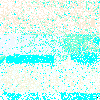

In [39]:
img

In [65]:
im.shape

(100, 100, 3)

In [69]:
np.array(img).shape

(100, 100, 3)

In [64]:
getClosestImage()

AttributeError: shape

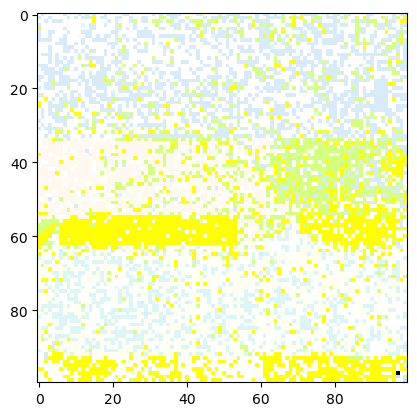

In [53]:
plt.imshow(im)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


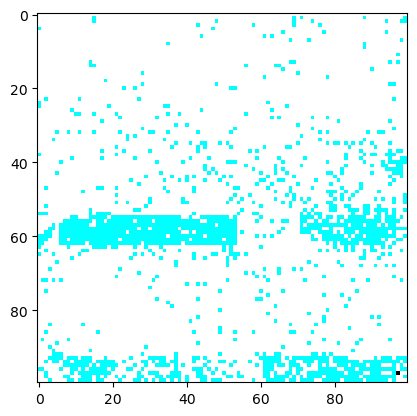

In [74]:
plt.imshow(getClosestImage(np.array(img).astype(np.uint8)))

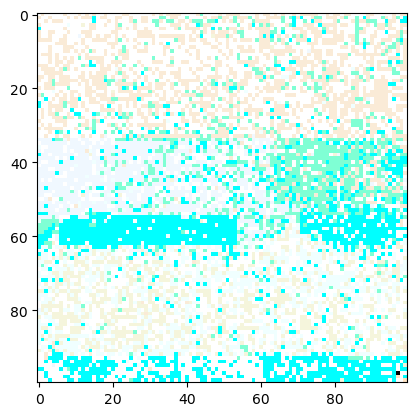

In [72]:
plt.imshow(img)

space_with_highest_range: 1
median_index: 5000
space_with_highest_range: 1
median_index: 2500
space_with_highest_range: 2
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 2
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 2500
space_with_highest_range: 0
median_index: 1250
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 0
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 1
median_index: 1250
space_with_highest_range: 1
median_index: 625
to quantize:  625
to quantize:  625
space_with_highest_range: 1
median_index: 625
to quantize:  625
to quantize:  625


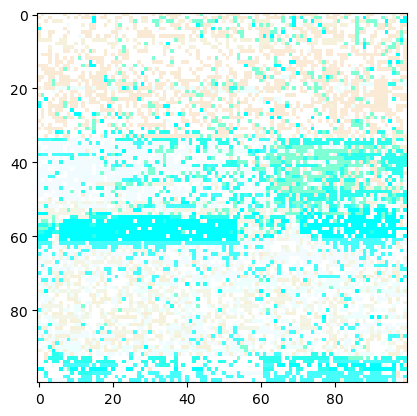

In [76]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
        
sample_img = imread('images 21.png')

def median_cut_quantize(img, img_arr):
    # when it reaches the end, color quantize
    print("to quantize: ", len(img_arr))
    r_average = np.mean(img_arr[:,0])
    g_average = np.mean(img_arr[:,1])
    b_average = np.mean(img_arr[:,2])
    
    for data in img_arr:
        sample_img[data[3]][data[4]] = [r_average, g_average, b_average]
    
def split_into_buckets(img, img_arr, depth):
    
    if len(img_arr) == 0:
        return 
        
    if depth == 0:
        median_cut_quantize(img, img_arr)
        return
    
    r_range = np.max(img_arr[:,0]) - np.min(img_arr[:,0])
    g_range = np.max(img_arr[:,1]) - np.min(img_arr[:,1])
    b_range = np.max(img_arr[:,2]) - np.min(img_arr[:,2])
    
    space_with_highest_range = 0

    if g_range >= r_range and g_range >= b_range:
        space_with_highest_range = 1
    elif b_range >= r_range and b_range >= g_range:
        space_with_highest_range = 2
    elif r_range >= b_range and r_range >= g_range:
        space_with_highest_range = 0

    print("space_with_highest_range:",space_with_highest_range)

    # sort the image pixels by color space with highest range 
    # and find the median and divide the array.
    img_arr = img_arr[img_arr[:,space_with_highest_range].argsort()]
    median_index = int((len(img_arr)+1)/2)
    print("median_index:", median_index)

    
    #split the array into two buckets along the median
    split_into_buckets(img, img_arr[0:median_index], depth-1)
    split_into_buckets(img, img_arr[median_index:], depth-1)
    
flattened_img_array = []
for rindex, rows in enumerate(sample_img):
    for cindex, color in enumerate(rows):
        flattened_img_array.append([color[0],color[1],color[2],rindex, cindex]) 
        
flattened_img_array = np.array(flattened_img_array)

# the 3rd parameter represents how many colors are needed in the power of 2. If the parameter 
# passed is 4 its means 2^4 = 16 colors
split_into_buckets(sample_img, flattened_img_array, 4)
plt.imshow(sample_img)


In [77]:
img = cv2.imread('images 21.png')

In [85]:
(img = [0,0,0])

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2070811373.py, line 1)

In [2]:
mask = (img == [255,255,255]).all(axis = 2, keepdims = True).astype(np.uint8)

In [3]:
mask = mask.reshape(100,100)

In [1]:
cv2.imshow(mask)

NameError: name 'cv2' is not defined

In [ ]:
import numpy as np
import cv2

img = cv2.imread('images 21.png')
mask = (img == [255,255,255]).all(axis = 2, keepdims = True).astype(np.uint8).reshape(100,100)
# mask = cv2.imread('mask2.png',0)

dst = cv2.inpaint(img,mask,3,cv2.INPAINT_TELEA)

cv2.imshow('dst',dst)